<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE6-WEEK3/m06w03_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Temperature Forecast

In [1]:
import torch
import torch.nn as nn

seed = 42
torch.manual_seed(seed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

## Tải dữ liệu

In [2]:
!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 162MB/s]


In [3]:
!unzip "./dataset.zip"

Archive:  ./dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


## Read data

In [4]:
data_path = '/content/dataset/weatherHistory.csv'
df = pd.read_csv(data_path)
univariate_df = df[['Temperature (C)']]
univariate_df.index = pd.to_datetime(df['Formatted Date']) # chuyển dữ liệu này thành index

<ipython-input-4-88a9dc6def73>:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  univariate_df.index = pd.to_datetime(df['Formatted Date']) # chuyển dữ liệu này thành index


In [5]:
univariate_df

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00+02:00,9.472222
2006-04-01 01:00:00+02:00,9.355556
2006-04-01 02:00:00+02:00,9.377778
2006-04-01 03:00:00+02:00,8.288889
2006-04-01 04:00:00+02:00,8.755556
...,...
2016-09-09 19:00:00+02:00,26.016667
2016-09-09 20:00:00+02:00,24.583333
2016-09-09 21:00:00+02:00,22.038889


In [6]:
# tạo một hàm slicing windown
input_size = 6
label_size = 1
offset = 1
def slicing_windown(df, df_start_index, df_end_index, input_size, label_size, offset):
  input_data = []
  label_data = []

  window_size = input_size + offset

  if df_end_index is None:
    df_end_index = len(df) - window_size

  for idx in range(df_start_index, df_end_index):
    feature_end_idx = idx + input_size
    label_start_idx = idx + window_size - offset
    label_end_idx = label_start_idx + label_size

    input_data.append(df[idx:feature_end_idx])
    label_data.append(df[label_start_idx:label_end_idx])

  return input_data, label_data

In [7]:
# chia dữ liệu thành các tệp train, val, test hiện có
train_size = 0.7
val_size = 0.2
train_end_idx = int(len(univariate_df) * train_size)
val_end_idx = train_end_idx + int(len(univariate_df) * val_size)

x_train, y_train = slicing_windown(univariate_df, 0, train_end_idx, input_size, label_size, offset)
x_val, y_val = slicing_windown(univariate_df, train_end_idx, val_end_idx, input_size, label_size, offset)
x_test, y_test = slicing_windown(univariate_df, val_end_idx, None, input_size, label_size, offset)

In [8]:
# xây dựng mô hình lấy dữ liệu
class WeatherForcast(Dataset): # Changed from 'def' to 'class' and inherited from 'Dataset'
  def __init__(self, input_data, label_data, transform=None):
    self.input_data = input_data
    self.label_data = label_data
    self.transform = transform

  def __len__(self):
    return len(self.input_data)

  def __getitem__(self, idx):
    input_data = self.input_data[idx]
    label_data = self.label_data[idx]

    if self.transform:
      input_data = self.transform(input_data)

    input_data = torch.tensor(input_data.values, dtype=torch.float32)
    label_data = torch.tensor(label_data.values, dtype=torch.float32)
    return input_data, label_data


In [9]:
# khai báo dataloader
train_dataset = WeatherForcast(x_train, y_train)
val_dataset = WeatherForcast(x_val, y_val)
test_dataset = WeatherForcast(x_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


In [10]:
class WeatherForecastModel(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers, dropout):
    super(WeatherForecastModel, self).__init__()
    self.lstm = nn.RNN(input_size, hidden_size,num_layers=n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.fc = nn.Linear(hidden_size, 1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x

In [11]:
input_size = 1
hidden_size = 8
n_layers = 3
dropout = 0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastModel(input_size, hidden_size, n_layers, dropout).to(device)

lr = 1e-3
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [12]:
def evaluate(model, test_loader, criterion, device):
  model.eval()  # Set the model to evaluation mode
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for ind, (x_batch, y_batch) in enumerate(test_loader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      y_pred = model(x_batch)
      loss = criterion(y_pred, y_batch)
      losses.append(loss.item())
  cal_loss = np.mean(losses)
  return cal_loss

In [13]:
def fit(model, train_loader, val_loader, optimizer, criterion, n_epochs, device):
  losses_train, losses_val = [], []
  accs_train, accs_val = [], []
  for epoch in range(n_epochs):
    batch_train_losses = []
    batch_train_accs = []
    batch_train_accs = []
    model = model.train()
    for ind, (x_batch, y_batch) in enumerate(train_loader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      y_pred = model(x_batch)
      loss = criterion(y_pred, y_batch)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    losses_train.append(np.mean(batch_train_losses))

    val_loss = evaluate(model, val_loader, criterion, device)
    losses_val.append(val_loss)
    print(f'EPOCH {epoch + 1}:\tTrain loss : {losses_train[-1]:.4f}\tVal loss : {losses_val[-1]:.4f}')

  return losses_train, losses_val


In [14]:
train_losses, val_losses = fit(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([61, 1, 1])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

EPOCH 1:	Train loss : 145.2996	Val loss : 77.4127
EPOCH 2:	Train loss : 102.6733	Val loss : 72.9101
EPOCH 3:	Train loss : 102.2455	Val loss : 72.6358
EPOCH 4:	Train loss : 102.0847	Val loss : 72.4704
EPOCH 5:	Train loss : 101.9646	Val loss : 72.2910
EPOCH 6:	Train loss : 101.9189	Val loss : 72.4376
EPOCH 7:	Train loss : 101.8078	Val loss : 72.6267
EPOCH 8:	Train loss : 101.7642	Val loss : 72.3965
EPOCH 9:	Train loss : 101.6416	Val loss : 72.2344
EPOCH 10:	Train loss : 101.5690	Val loss : 72.1583
EPOCH 11:	Train loss : 101.4525	Val loss : 72.3778
EPOCH 12:	Train loss : 101.2711	Val loss : 72.3947
EPOCH 13:	Train loss : 101.2470	Val loss : 72.3078
EPOCH 14:	Train loss : 101.1738	Val loss : 72.3607
EPOCH 15:	Train loss : 101.0546	Val loss : 72.2083
EPOCH 16:	Train loss : 100.9492	Val loss : 72.3815
EPOCH 17:	Train loss : 100.8688	Val loss : 72.5103
EPOCH 18:	Train loss : 100.8212	Val loss : 72.1828
EPOCH 19:	Train loss : 100.7101	Val loss : 72.4299
EPOCH 20:	Train loss : 100.6253	Val loss

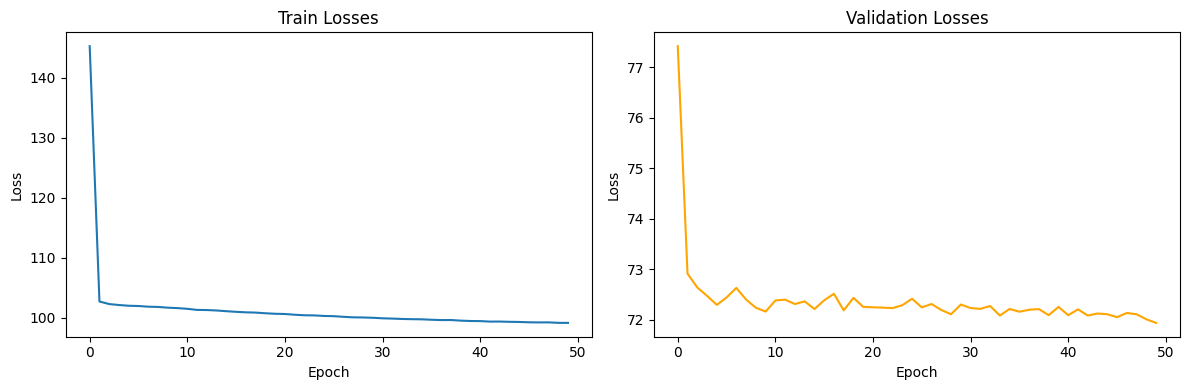

In [19]:
# prompt: ý tôi là tạo ra hai hình losses cho val và train, hình bên trái là train losses, bên phải là val losses

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses)
axes[0].set_title('Train Losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')


axes[1].plot(val_losses, color = 'orange')
axes[1].set_title('Validation Losses')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()